# TinyML LLM Benchmark - Scatter Plot Analysis

This notebook generates visualization plots for TinyML LLM benchmark data, including:
- **Scatter plots**: Time vs Token consumption by task and status
- **Comparison plots**: Side-by-side dataset comparisons
- **Combo plots**: Clustered bars with success rate overlay

## Data Requirements
- Processed CSV files in `processed_data/` directory
- Files follow naming pattern: `clean_{model}_{batch_id}_{processor_type}_batch.csv`

In [1228]:
# 1.1 Imports and Path Setup
import os, re
from typing import Tuple, Dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib import font_manager

# Determine directories relative to this notebook
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
date = os.path.basename(parent_dir)  # Inferred from parent directory name

# Default data directory
data_dir = os.path.join(parent_dir, "processed_data")

# Directory to save figures
save_dir = os.path.join(parent_dir, "tex")
os.makedirs(save_dir, exist_ok=True)

print(f"Date: {date}")
print(f"Data directory: {data_dir}")
print(f"Save directory: {save_dir}")

Date: 03.22
Data directory: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/processed_data
Save directory: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/tex


---
## 1. Setup and Configuration

In [1229]:
# 1.2 Global Style Configuration
# ============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# Configure CMU font (manually add font files to matplotlib)
cmu_font_dir = '/usr/share/fonts/truetype/cmu/'
if os.path.exists(cmu_font_dir):
    for font_file in [f for f in os.listdir(cmu_font_dir) if f.endswith('.ttf')]:
        fm.fontManager.addfont(os.path.join(cmu_font_dir, font_file))

# Set global font settings
plt.rcParams['font.family'] = 'CMU Bright' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'

# Font Configuration - Consolidated Settings for All Diagrams
# ============================================================================
universal_fontweight = "bold"

# Font Weights (by diagram type)
title_fontweight = universal_fontweight
label_fontweight = universal_fontweight
tick_fontweight = universal_fontweight
scatter_legend_fontweight = "ultralight"

# title_fontweight = universal_fontweight
# label_fontweight = universal_fontweight
# tick_fontweight = universal_fontweight
legend_fontweight = universal_fontweight

# title_fontweight = universal_fontweight
# label_fontweight = universal_fontweight
# tick_fontweight = universal_fontweight
# legend_fontweight = universal_fontweight
annotation_fontweight = "bold"

# Font Sizes (by diagram type)
title_fontsize = 27
label_fontsize = 16
tick_fontsize = 16
legend_fontsize = 13


annotation_fontsize = 15
best_label_fontsize = 13

# Legacy variable names (backward compatibility)
# title_fontweight = title_fontweight
# label_fontweight = label_fontweight
# tick_fontweight = tick_fontweight
# legend_fontweight = legend_fontweight
# title_fontsize = title_fontsize
# label_fontsize = label_fontsize
# tick_fontsize = tick_fontsize
# legend_fontsize = legend_fontsize
# tick_fontsize = tick_fontsize
# annotation_fontsize = annotation_fontsize
# best_label_fontsize = best_label_fontsize

# Visual properties
marker_size = 60
line_width = 3
marker_linewidth = 1.5
bar_width = 0.127
grid_alpha = 0.6

# Matplotlib font embedding (for PDF export)
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

print("✓ Global style configuration loaded")

✓ Global style configuration loaded


---
## 2. Data Processing Functions

In [1230]:
# 2.1 Data Processing Helper Functions

def get_model_name(tags: str) -> str:
    """Extract model name from tags string."""
    known_values = {"benchmark", "experiment", "data_processor", "model_converter", "sketch_generator"}
    cleaned_tags = [
        tag.strip()
        for tag in tags.replace("{", "").replace("}", "").replace("[", "").replace("]", "").replace("'", "").replace('"', "").split(",")
    ]
    return next((tag for tag in cleaned_tags if tag and tag not in known_values), None)


def process_batch_csvs(dir_path: str) -> Tuple[pd.DataFrame, Dict[str, Dict[str, str]]]:
    """
    Load and combine all batch CSV files from a directory.
    
    Returns:
        Tuple of (combined DataFrame, batch info dict)
    """
    processor_names = {
        "dp": {"full_name": "Data Processor", "short_name": "DP", "processor_type": "data_processor"},
        "mc": {"full_name": "Model Converter", "short_name": "MC", "processor_type": "model_converter"},
        "sg": {"full_name": "Sketch Generator", "short_name": "SG", "processor_type": "sketch_generator"},
    }
    dfs = []
    batch_info: Dict[str, Dict[str, str]] = {}
    pattern = r"clean_(.+?)_([a-z]{2})_batch\.csv"
    
    if not os.path.isdir(dir_path):
        return pd.DataFrame(), {}
    
    for filename in os.listdir(dir_path):
        if filename.startswith("clean_") and filename.endswith("_batch.csv"):
            match = re.match(pattern, filename)
            if match and match.group(2) in processor_names:
                proc_key = match.group(2)
                info = processor_names[proc_key]
                batch_id = match.group(1) + "_" + proc_key
                file_path = os.path.join(dir_path, filename)
                
                try:
                    df = pd.read_csv(file_path)
                except Exception as e:
                    print(f"Failed reading {file_path}: {e}")
                    continue
                
                df["processor_type"] = info["processor_type"]
                df["batch_id"] = batch_id
                dfs.append(df)
                
                if len(df) > 0:
                    batch_info[batch_id] = {
                        "processor_type": info["processor_type"],
                        "full_name": info["full_name"],
                        "short_name": info["short_name"],
                        "model_name": get_model_name(str(df.iloc[0].get("tags", ""))),
                    }
    
    if dfs:
        return pd.concat(dfs, ignore_index=True), batch_info
    return pd.DataFrame(), {}


def extract_model_name(batch_info: Dict[str, Dict[str, str]]) -> str:
    """Extract and normalize model name from batch info."""
    if not batch_info:
        return "unknown_model"
    model_name = next(iter(batch_info.values())).get("model_name") or "unknown_model"
    
    # Normalize common model names
    if model_name.startswith("phi4"):
        model_name = "phi4:14b"
    elif model_name.startswith("llama3.1"):
        model_name = "llama3.1:8b"
    
    return model_name

print("✓ Data processing functions loaded")

✓ Data processing functions loaded


In [1231]:
# 2.2 Load Data from Subdirectories

subdir_results = []  # Store tuples: (dir_name, combined_df, batch_info)

if os.path.isdir(data_dir):
    for sub in sorted(os.listdir(data_dir)):
        sub_path = os.path.join(data_dir, sub)
        if not os.path.isdir(sub_path):
            continue
        
        combined_df, batch_info = process_batch_csvs(sub_path)
        print(f"  {sub:25s} → {combined_df.shape[0]:3d} rows, {len(batch_info)} batches")
        
        if not combined_df.empty and batch_info:
            subdir_results.append((sub, combined_df, batch_info))
else:
    print(f"⚠ Data directory not found: {data_dir}")

if not subdir_results:
    print("⚠ No data loaded. Check that processed_data directory contains CSV files.")
else:
    print(f"\n✓ Loaded {len(subdir_results)} dataset(s)")

  codestral_87c9            →  90 rows, 3 batches

✓ Loaded 1 dataset(s)


In [1232]:
# 2.3 Task Color Configuration

# Task color mapping (consistent across all plots)
task_colors = {
    "Model Converter": "blue",
    "Data Processor": "green", 
    "Sketch Generator": "red",
}

# Processor name mappings for labels
processor_name_mappings = {
    "Model Converter": ["Model Conversion", "MC"],
    "Data Processor": ["Data Processing", "DP"],
    "Sketch Generator": ["Sketch Generation", "SG"]
}

print("✓ Color configuration loaded")

✓ Color configuration loaded


---
## 3. Visualization Functions

In [1233]:
# 3.1 Scatter Plot Function

def generate_scatter(df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]], 
                    model_name: str, date: str, save_dir: str):
    """Generate scatter plot showing time vs token consumption by task and status."""
    if df.empty or not batch_info:
        print("⚠ Empty dataframe or missing batch_info; skipping plot.")
        return

    # Add task mapping if not present
    if "task_full_name" not in df.columns:
        def map_full_name(bid):
            info = batch_info.get(bid)
            return info["full_name"] if info else "Unknown"
        df["task_full_name"] = df["batch_id"].map(map_full_name)

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))

    # Plot each task with success (o) and failure (x) markers
    for task_name, color in task_colors.items():
        task_df = df[df["task_full_name"] == task_name]
        if task_df.empty:
            continue
        
        success = task_df[task_df["status"] == "success"]
        fail = task_df[task_df["status"] == "failure"]
        
        if not success.empty:
            plt.scatter(success["latency"], success["total_tokens"], 
                       color=color, alpha=0.6, marker="o", s=marker_size)
        if not fail.empty:
            plt.scatter(fail["latency"], fail["total_tokens"], 
                       color=color, alpha=0.6, marker="x", s=marker_size)

    # Labels and title
    plt.xlabel("Time Consumption (seconds)", fontsize=label_fontsize, 
               fontweight=label_fontweight)
    plt.ylabel("Token Consumption", fontsize=label_fontsize, 
               fontweight=label_fontweight)
    plt.title(f"Time-Token Consumption Patterns Across Tasks: {model_name}", 
             fontsize=title_fontsize, loc="center", x=0.46, y=1.03, 
             fontweight=title_fontweight)
    plt.tick_params(axis="both", which="major", labelsize=tick_fontsize)

    # Format axes with thousands commas
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Create legends
    task_handles = [plt.scatter([], [], color=color, marker="o", s=marker_size) 
                   for color in task_colors.values()]
    task_labels = list(task_colors.keys())
    
    status_handles = [
        plt.scatter([], [], color="gray", marker="o", s=marker_size),
        plt.scatter([], [], color="gray", marker="x", s=marker_size),
    ]
    status_labels = ["Success", "Failure"]

    # legend_title_prop = 
    first_legend = plt.legend(task_handles, task_labels, loc="upper right", 
                             bbox_to_anchor=(0.995, 1.0), 
                             prop={"weight": scatter_legend_fontweight, "size": legend_fontsize}, 
                             frameon=True, title="Tasks", title_fontproperties={"weight": scatter_legend_fontweight, "size": legend_fontsize, 
                        "style": "italic"})
    plt.gca().add_artist(first_legend)
    plt.legend(status_handles, status_labels, loc="upper right", 
              bbox_to_anchor=(0.995, 0.82), 
              prop={"weight": scatter_legend_fontweight, "size": legend_fontsize}, 
              frameon=True, title="Status", title_fontproperties={"weight": scatter_legend_fontweight, "size": legend_fontsize, 
                        "style": "italic"})

    plt.grid(True, linestyle="-", alpha=0.5)
    plt.tight_layout()

    # Save and display
    outfile = os.path.join(save_dir, f"scatter_plot_{model_name}_{date}.pdf")
    plt.savefig(outfile, format="pdf", dpi=400, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved: {outfile}")

print("✓ Scatter plot function loaded")

✓ Scatter plot function loaded


In [1234]:
# 3.2 Dataset Comparison Configuration

import os 
cwd = os.getcwd()
try:
    cwd = cwd.split("data_analysis")[0]
except:
    pass

FOREIGN_DATASET_DIR = os.path.join(cwd, "data_analysis/2025/03.27/processed_data/codestral_a190")

print(f"Foreign dataset: {FOREIGN_DATASET_DIR}")

Foreign dataset: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.27/processed_data/codestral_a190


In [1235]:
# 3.3 Dataset Comparison Functions

def load_and_plot_unified_dataset(dir_path: str, ax, title_suffix=""):
    """Load and plot unified scatter for a dataset on the given axis."""
    combined_df, batch_info = process_batch_csvs(dir_path)
    if combined_df.empty or not batch_info:
        print(f"⚠ No data found in {dir_path}")
        return None, None
    
    # Add task mapping
    def map_full_name(bid):
        info = batch_info.get(bid)
        return info["full_name"] if info else "Unknown"
    combined_df["task_full_name"] = combined_df["batch_id"].map(map_full_name)
    
    # Scale tokens to thousands
    combined_df["total_tokens_k"] = combined_df["total_tokens"] / 1000
    
    # Plot all tasks
    legend_items = {}
    for task_name, color in task_colors.items():
        task_data = combined_df[combined_df["task_full_name"] == task_name]
        if task_data.empty:
            continue
        
        # Successful runs
        success = task_data[task_data["status"] == "success"]
        if not success.empty:
            sc_s = ax.scatter(success["latency"], success["total_tokens_k"], 
                            color=color, alpha=0.6, marker="o", s=marker_size)
            legend_items[(task_name, "Success")] = sc_s
        
        # Failed runs
        failed = task_data[task_data["status"] == "failure"]
        if not failed.empty:
            sc_f = ax.scatter(failed["latency"], failed["total_tokens_k"], 
                            color=color, alpha=0.6, marker="x", s=marker_size)
            legend_items[(task_name, "Failure")] = sc_f
    
    model_name = extract_model_name(batch_info)
    # <CHANGES>
    ax.set_title(f"Model: {model_name.split(':')[0].capitalize()} 22B\nParameters: {title_suffix}", 
                fontsize=label_fontsize, fontweight=label_fontweight)
    ax.set_xlabel("Time Consumption (seconds)", fontsize=label_fontsize, 
                  fontweight=label_fontweight)
    ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
    # </CHANGES>
    ax.grid(True, linestyle="-", alpha=0.1)
    
    # Format axes
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
    
    return combined_df, legend_items


def compare_current_vs_foreign_datasets():
    """Generate side-by-side comparison of current vs foreign dataset."""
    if not FOREIGN_DATASET_DIR:
        print("⚠ FOREIGN_DATASET_DIR not set")
        return
    
    if not subdir_results:
        print("⚠ No current dataset loaded")
        return
    
    # Use first subdirectory as current dataset
    current_subdir, current_df, current_batch_info = subdir_results[0]
    current_dir = os.path.join(data_dir, current_subdir)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    
    # Plot datasets
    current_combined, current_legend = load_and_plot_unified_dataset(
        current_dir, axes[0], "None")
    foreign_combined, foreign_legend = load_and_plot_unified_dataset(
        FOREIGN_DATASET_DIR, axes[1], "temperature=0.1, top_p=0.3")
    
    # Unified axis limits
    if current_combined is not None and foreign_combined is not None:
        all_latency = pd.concat([current_combined["latency"], foreign_combined["latency"]])
        all_tokens_k = pd.concat([current_combined["total_tokens_k"], 
                                 foreign_combined["total_tokens_k"]])
        
        x_min, x_max = all_latency.min(), all_latency.max()
        y_min, y_max = all_tokens_k.min(), all_tokens_k.max()
        
        x_padding = (x_max - x_min) * 0.02
        y_padding = (y_max - y_min) * 0.05
        
        for ax in axes:
            ax.set_xlim(x_min - x_padding, x_max + x_padding)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # <CHANGES>
    axes[0].set_ylabel("Token Consumption (thousands)", fontsize=label_fontsize, 
                       fontweight=label_fontweight)
    # </CHANGES>
    
    # Unified legend
    all_legend_items = {}
    if current_legend:
        all_legend_items.update(current_legend)
    if foreign_legend:
        all_legend_items.update(foreign_legend)
    
    legend_handles = []
    legend_labels = []
    
    for task in ["Data Processor", "Model Converter", "Sketch Generator"]:
        for status in ["Success", "Failure"]:
            key = (task, status)
            if key in all_legend_items:
                marker = "o" if status == "Success" else "x"
                handle = plt.Line2D([], [], color=task_colors[task], marker=marker, 
                                  linestyle="None", markersize=8)
                legend_handles.append(handle)
                legend_labels.append(f"{processor_name_mappings[task][1]} - {status}")
    
    fig.legend(legend_handles, legend_labels, 
              loc="upper right", bbox_to_anchor=(0.237, 0.928),
              prop={"size": legend_fontsize, 
                    "weight": "light", "family": "monospace"},
              title="Tasks",
              title_fontproperties={"size": legend_fontsize, 
                                   "weight": label_fontweight, 
                                   "style": "italic"})
    
    plt.tight_layout(rect=[0, 0, 1.1, 1])
    
    # Save
    output_file = os.path.join(save_dir, f"scatter_{date}.pdf")
    plt.savefig(output_file, format="pdf", dpi=400, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved: {output_file}")

print("✓ Comparison functions loaded")

✓ Comparison functions loaded


In [1236]:
# 3.4 Combo Bar/Line Plot Function

def generate_performance_plot(stages, time_data, token_data, success_rate, 
                                    date, save_dir, model_name=""):
    """
    Generate combo plot with grouped bars (time/token) and success rate line.
    
    Parameters:
    -----------
    stages : list
        Stage names (e.g., ['SG1', 'SG2', 'SG3'])
    time_data : dict
        Time consumption with keys 'overall', 'pass', 'fail'
    token_data : dict
        Token consumption with keys 'overall', 'pass', 'fail'
    success_rate : list
        Success rate for each stage (as decimal, e.g., 0.25 = 25%)
    date : str
        Date string for file naming
    save_dir : str
        Directory to save PDF
    model_name : str, optional
        Model name for title
    """
    import numpy as np
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Configuration
    x = np.arange(len(stages))
    token_colors = {"base": "#99c6cc", "edge": "#0d7d87"}
    time_colors = {"base": "#eddca5", "edge": "#c99b38"}
    hatchs = {"fail": "...", "pass": "xxx"}
    palette = {"Token": (token_colors, token_data), "Time": (time_colors, time_data)}
    success_color = "#c31e23"
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    # Plot grouped bars
    for i, (metric, (colors, data)) in enumerate(palette.items()):
        best_indices = {k: int(np.argmin(v)) for k, v in data.items()}
    
        for j, key in enumerate(["overall", "pass", "fail"]):
            offset = (i * 3 + j - 3) * bar_width
            ax = ax1 if metric == "Token" else ax2
    
            for idx, value in enumerate(data[key]):
                is_best = (idx == best_indices[key])
    
                # Main bar
                bar = ax.bar(
                    x[idx] + offset, value, bar_width,
                    color=colors["edge" if key == "overall" else "base"],
                    alpha=1.0,
                    edgecolor=None if key == "overall" else colors["edge"],
                    hatch=None if key == "overall" else hatchs[key],
                    linewidth=marker_linewidth if key != "overall" else 0,
                    zorder=3
                )
                
                # Highlight best
                if is_best:
                    ax.plot([x[idx] + offset - bar_width/2.2, x[idx] + offset + bar_width/2.3],
                           [value, value], color='black', lw=2, zorder=6)
                    ax.text(x[idx] + offset, value, "best", ha='center', va='bottom',
                           fontsize=best_label_fontsize, color='black', 
                           style='italic', zorder=7)
    
    # Success rate line
    success_scaled = np.array(success_rate) * 200 + 6
    ax2.plot(x, success_scaled, "o-", color=success_color, lw=line_width, ms=10, 
             label="Success Rate", zorder=10)
    
    # Axes and labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(stages, fontsize=tick_fontsize, fontweight=tick_fontweight)
    ax1.set_ylabel("Token Consumption (thousands)", fontsize=label_fontsize, 
                   fontweight=label_fontweight)
    ax2.set_ylabel("Time Consumption(s)", fontsize=label_fontsize, 
                   fontweight=label_fontweight)
    ax1.tick_params(axis="y", labelsize=tick_fontsize)
    ax2.tick_params(axis="y", labelsize=tick_fontsize)
    ax1.grid(axis="y", linestyle="--", alpha=grid_alpha)
    
    # Legend
    legend_elements = [
        Patch(facecolor=c["edge"], alpha=1.0, label=f"{name} Overall")
        for name, (c, _) in palette.items()
    ] + [
        Patch(facecolor=c["base"], alpha=1.0, edgecolor=c["edge"], hatch=hatchs[k], 
              label=f"{name} {k.title()}")
        for name, (c, _) in palette.items() for k in ["pass", "fail"]
    ] + [
        Line2D([0], [0], color=success_color, lw=3, marker="o", ms=10, label="Success Rate")
    ]
    
    order = ["Token Overall", "Token Pass", "Token Fail",
             "Time Overall", "Time Pass", "Time Fail", "Success Rate"]
    
    handles = sorted(legend_elements,
                    key=lambda h: order.index(h.get_label()) if h.get_label() in order else 999)
    
    ax1.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.085), 
              ncol=7, fontsize=legend_fontsize, framealpha=0.95,columnspacing=1.1,)
    
    # Success rate annotations
    for i, rate in enumerate(success_rate):
        ax2.annotate(f"{rate:.1%}", xy=(x[i], success_scaled[i]), xytext=(0, 17),
                     textcoords="offset points", ha="center", color=success_color,
                     fontsize=annotation_fontsize, fontweight=annotation_fontweight,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                               edgecolor=success_color, alpha=0.8))
    
    # Save
    plt.tight_layout()
    save_path = os.path.join(save_dir, f"combo_performance_{date}.pdf")
    plt.savefig(save_path, format="pdf", dpi=400, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved: {save_path}")
    
    return fig, ax1, ax2

print("✓ Combo plot function loaded")

✓ Combo plot function loaded


### 3.4 Combo Plot Function

TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped


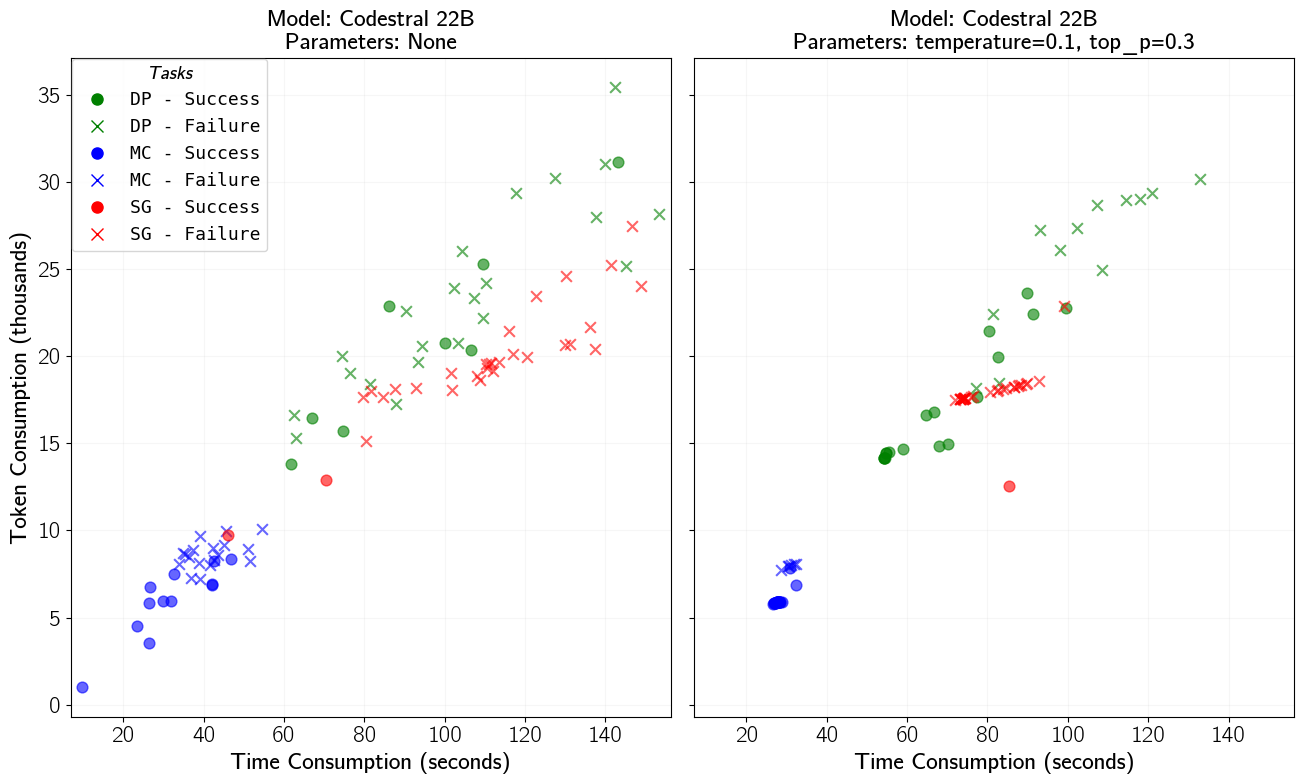

✓ Saved: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/tex/scatter_03.22.pdf


In [1237]:
# 5.1 Generate Comparison Plot

compare_current_vs_foreign_datasets()

In [1238]:
# Font Configuration Reference (Optional)
# Run this cell to see available fonts and configuration options

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

print("="*80)
print("FONT CONFIGURATION REFERENCE")
print("="*80)

# ============================================================================
# CMU FONT FAMILIES
# ============================================================================
all_fonts = sorted(set([f.name for f in fm.fontManager.ttflist]))
cmu_fonts = [f for f in all_fonts if 'CMU' in f]

print(f"\n{'CMU Font Families Available':-^80}")
print(f"\nTotal CMU fonts installed: {len(cmu_fonts)}")
print("\nComplete list of CMU font families:")
for i, font in enumerate(cmu_fonts, 1):
    print(f"  {i:2d}. {font}")

# ============================================================================
# FONT WEIGHT OPTIONS
# ============================================================================
print(f"\n{'Font Weight Options':-^80}")
print("\nNumeric values (0-1000):")
print("  • 100 (Thin/Hairline)")
print("  • 200 (Extra Light/Ultra Light)")
print("  • 300 (Light)")
print("  • 400 (Normal/Regular)")
print("  • 500 (Medium)")
print("  • 600 (Semi Bold/Demi Bold)")
print("  • 700 (Bold)")
print("  • 800 (Extra Bold/Ultra Bold)")
print("  • 900 (Black/Heavy)")

print("\nString aliases:")
print("  • 'ultralight' or 'extra light' → 200")
print("  • 'light' → 300")
print("  • 'normal' or 'regular' → 400")
print("  • 'medium' → 500")
print("  • 'semibold' or 'demibold' → 600")
print("  • 'bold' → 700")
print("  • 'extra bold' or 'ultrabold' → 800")
print("  • 'black' or 'heavy' → 900")

# ============================================================================
# FONT FAMILY OPTIONS
# ============================================================================
print(f"\n{'Font Family Options (font.family)':-^80}")
print("\n  • 'serif' - Serif fonts (e.g., Times New Roman)")
print("  • 'sans-serif' - Sans-serif fonts (e.g., Arial, Helvetica)")
print("  • 'cursive' - Cursive fonts")
print("  • 'fantasy' - Fantasy fonts")
print("  • 'monospace' - Monospace fonts (e.g., Courier)")
print("  • Any specific font name (e.g., 'CMU Bright', 'CMU Sans Serif')")

# ============================================================================
# MATHTEXT FONTSET OPTIONS
# ============================================================================
print(f"\n{'Mathtext Fontset Options (mathtext.fontset)':-^80}")
print("\n  • 'cm' - Computer Modern (LaTeX default)")
print("  • 'stix' - STIX fonts")
print("  • 'stixsans' - STIX sans-serif")
print("  • 'dejavusans' - DejaVu Sans")
print("  • 'dejavuserif' - DejaVu Serif")
print("  • 'custom' - Custom font configuration")

# ============================================================================
# CURRENT SETTINGS
# ============================================================================
print(f"\n{'Current Settings':-^80}")
print(f"\n  Font family: {plt.rcParams['font.family']}")
print(f"  Mathtext fontset: {plt.rcParams['mathtext.fontset']}")
print(f"  Universal fontweight: {universal_fontweight}")
print(f"  Total fonts available in system: {len(all_fonts)}")

print("\n" + "="*80)

FONT CONFIGURATION REFERENCE

--------------------------CMU Font Families Available---------------------------

Total CMU fonts installed: 10

Complete list of CMU font families:
   1. CMU Bright
   2. CMU Classical Serif
   3. CMU Concrete
   4. CMU Sans Serif
   5. CMU Sans Serif Demi Condensed
   6. CMU Serif
   7. CMU Serif Extra
   8. CMU Serif Upright Italic
   9. CMU Typewriter Text
  10. CMU Typewriter Text Variable Width

------------------------------Font Weight Options-------------------------------

Numeric values (0-1000):
  • 100 (Thin/Hairline)
  • 200 (Extra Light/Ultra Light)
  • 300 (Light)
  • 400 (Normal/Regular)
  • 500 (Medium)
  • 600 (Semi Bold/Demi Bold)
  • 700 (Bold)
  • 800 (Extra Bold/Ultra Bold)
  • 900 (Black/Heavy)

String aliases:
  • 'ultralight' or 'extra light' → 200
  • 'light' → 300
  • 'normal' or 'regular' → 400
  • 'medium' → 500
  • 'semibold' or 'demibold' → 600
  • 'bold' → 700
  • 'extra bold' or 'ultrabold' → 800
  • 'black' or 'heavy' → 90

---
## Appendix: Font Configuration Reference

The cell below shows available font options. Run it if you need to change font settings.

TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped


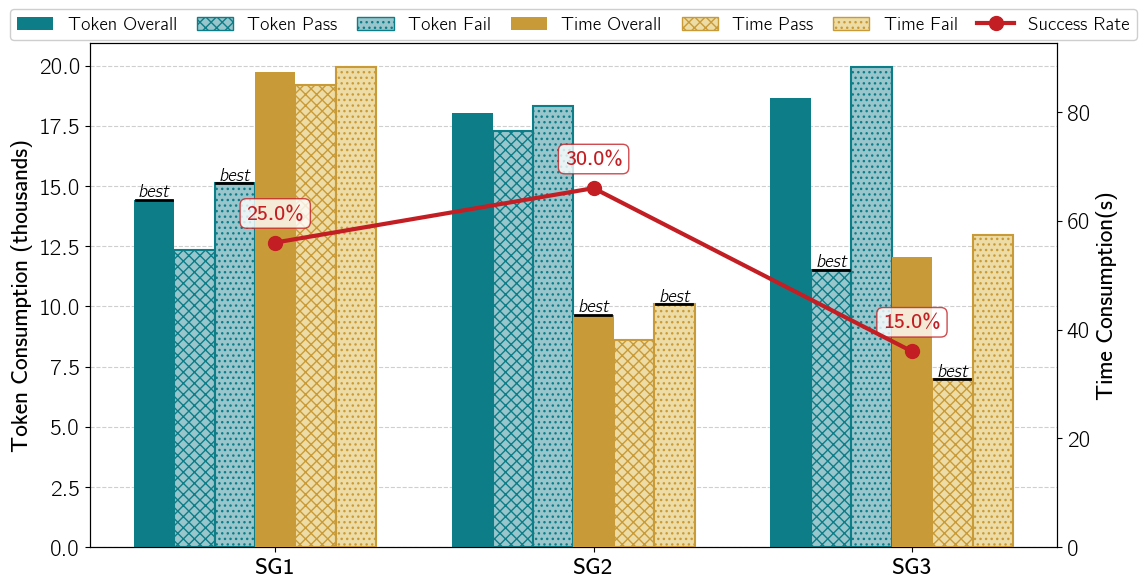

✓ Saved: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/tex/combo_performance_03.22.pdf


(<Figure size 1200x600 with 2 Axes>,
 <Axes: ylabel='Token Consumption (thousands)'>,
 <Axes: ylabel='Time Consumption(s)'>)

In [1239]:
# 5.4 Generate Combo Performance Plot

# Example data (replace with actual data from your analysis)
stages = ['SG1', 'SG2', 'SG3']
time_data = {
    "overall": [87.42, 42.76, 53.39], 
    "pass": [85.02, 38.18, 30.87], 
    "fail": [88.22, 44.72, 57.36]
}
token_data = {
    "overall": [14.435, 18.014, 18.671], 
    "pass": [12.356, 17.299, 11.522], 
    "fail": [15.128, 18.320, 19.933]
}
success_rate = [0.25, 0.30, 0.15]

generate_performance_plot(stages, time_data, token_data, success_rate, date, save_dir)

In [1240]:
# 5.3 Generate LaTeX Performance Table

# generate_latex_performance_table()

In [1241]:
# 5.2 Calculate and Display Statistics

# calculate_processor_statistics()ae

---
## 4. Analysis and Reporting Functions

---
## 5. Execute Analysis

Run the cells below to generate plots and statistics.

---
## 6. Heatmap Analysis: PSG vs TPUSG Success Rates

Reading heatmap data from: /home/han/Projects/reference-benchmark-tinyml_llm/heatmap_data_psg_vs_tpusg.csv

Heatmap data loaded from file:
                        psg  tpusg
model_label                       
Codestral:22B-NP       50.0   28.6
Codestral:22B-P        10.0   11.5
Gemma3:27B-NP          53.3    2.3
Gemma3:27B-P           71.2    0.0
Phi4:14B-NP            77.8   95.1
Phi4:14B-P            100.0  100.0
Qwen2.5-Coder:14B-NP   52.2   92.0
Qwen2.5-Coder:14B-P     4.6  100.0
Qwen2.5-Coder:32B-NP   50.0   96.7
Qwen2.5-Coder:32B-P    39.7   33.9

Data shape: (10, 2)
Models: ['Codestral:22B-NP', 'Codestral:22B-P ', 'Gemma3:27B-NP', 'Gemma3:27B-P ', 'Phi4:14B-NP', 'Phi4:14B-P ', 'Qwen2.5-Coder:14B-NP', 'Qwen2.5-Coder:14B-P ', 'Qwen2.5-Coder:32B-NP', 'Qwen2.5-Coder:32B-P ']


TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped
TeX  NOT subset; don't know how to subset; dropped


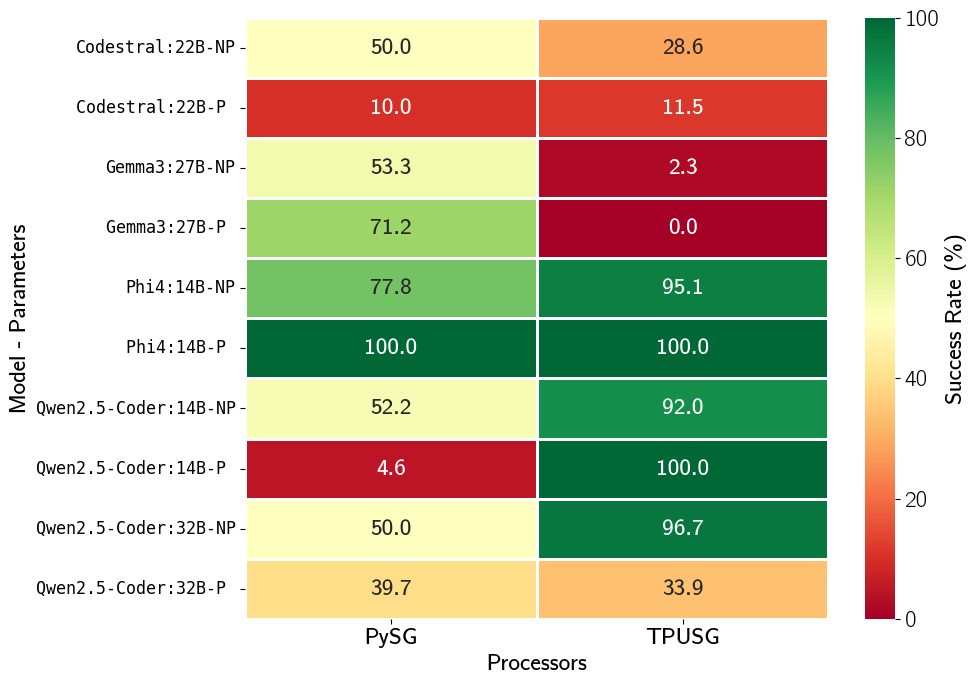

✓ Saved: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/tex/heatmap_03.22.pdf


In [1242]:
# 6.1 Heatmap Data Preparation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <CHANGES>
# Read data from CSV file in project root
heatmap_data_file = os.path.join(cwd, "heatmap_data_psg_vs_tpusg.csv")

if not os.path.exists(heatmap_data_file):
    print(f"⚠ Warning: Heatmap data file not found at {heatmap_data_file}")
    print("Looking for alternative locations...")
    # Try alternative location
    heatmap_data_file = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(parent_dir))), 
                                     "heatmap_data_psg_vs_tpusg.csv")

print(f"Reading heatmap data from: {heatmap_data_file}")
df = pd.read_csv(heatmap_data_file)
# </CHANGES>

# <CHANGES>
# Create model labels with parameter suffix - no padding, natural width
# Add trailing space after 'P' to align dashes in monospace font
df['model_label'] = df.apply(
    lambda row: f"{row['model_config']}-{'P ' if row['parameters'] else 'NP'}",
    axis=1
)
# </CHANGES>

# Pivot data for heatmap
heatmap_data = df.pivot(index='model_label', columns=['psg', 'tpusg'], values=['psg', 'tpusg'])

# Restructure to have processors as columns
heatmap_matrix = df[['model_label', 'psg', 'tpusg']].set_index('model_label')

print("\nHeatmap data loaded from file:")
print(heatmap_matrix)
print(f"\nData shape: {heatmap_matrix.shape}")
print(f"Models: {list(heatmap_matrix.index)}")


# 6.2 Generate Heatmap

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Create heatmap using seaborn
sns.heatmap(heatmap_matrix, 
            annot=True,  # Show values in cells
            fmt='.1f',   # Format to 1 decimal place
            cmap='RdYlGn',  # Red-Yellow-Green colormap
            vmin=0,      # Minimum value for colorscale
            vmax=100,    # Maximum value for colorscale
            linewidths=2,  # Width of lines between cells
            linecolor='white',  # Color of lines
            cbar_kws={'label': 'Success Rate (%)'},  # Colorbar label
            ax=ax,
            # <CHANGES>
            annot_kws={"size":legend_fontsize+3,"weight":"bold"})  # Remove bold for cell annotations
            # </CHANGES>

# Customize plot
ax.set_xlabel('Processors', fontsize=label_fontsize, fontweight=label_fontweight)
ax.set_ylabel('Model - Parameters', fontsize=label_fontsize, fontweight=label_fontweight)
# ax.set_title('Success Rate Comparison: PySG vs TPUSG\nAcross Model Configurations', 
#              fontsize=title_fontsize, fontweight=title_fontweight, pad=20)

# Rename columns to match the image
ax.set_xticklabels(['PySG', 'TPUSG'], fontsize=tick_fontsize, fontweight=tick_fontweight)
# <CHANGES>
# Use monospace font for y-tick labels with normal weight for better readability
# The trailing space after 'P' ensures dash alignment in monospace font
ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_fontsize-4, fontweight="normal", 
                   rotation=0, fontfamily='monospace')
# </CHANGES>

# Adjust colorbar
cbar = ax.collections[0].colorbar
cbar.set_label('Success Rate (%)', fontsize=label_fontsize, fontweight=label_fontweight)
cbar.ax.tick_params(labelsize=tick_fontsize)

plt.tight_layout()

# Save the figure
output_file = os.path.join(save_dir, f"heatmap_{date}.pdf")
plt.savefig(output_file, format="pdf", dpi=400, bbox_inches="tight")
plt.show()

print(f"✓ Saved: {output_file}")


---
## 7. Font Configuration Reference

Complete listing of available fonts and matplotlib configuration options.

In [1243]:
# 7.1 Print All Available Fonts and Configuration Options

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

print("="*100)
print(" " * 35 + "FONT CONFIGURATION REFERENCE")
print("="*100)

# ============================================================================
# ALL FONT FAMILIES
# ============================================================================
all_fonts = sorted(set([f.name for f in fm.fontManager.ttflist]))

print(f"\n{'ALL FONT FAMILIES AVAILABLE':-^100}")
print(f"\nTotal fonts installed: {len(all_fonts)}\n")

# Group fonts by first letter for easier reading
from itertools import groupby

for letter, fonts in groupby(all_fonts, key=lambda x: x[0].upper()):
    if letter == "c":
        font_list = list(fonts)
        print(f"\n{letter}")
        print("-" * 100)
        for i, font in enumerate(font_list, 1):
            print(f"  {i:3d}. {font}")

# ============================================================================
# CMU FONT FAMILIES
# ============================================================================
cmu_fonts = [f for f in all_fonts if 'CMU' in f or 'Computer Modern' in f]

print(f"\n\n{'CMU/COMPUTER MODERN FONT FAMILIES':-^100}")
print(f"\nTotal CMU fonts installed: {len(cmu_fonts)}\n")
for i, font in enumerate(cmu_fonts, 1):
    print(f"  {i:2d}. {font}")

# ============================================================================
# FONT WEIGHT OPTIONS
# ============================================================================
print(f"\n\n{'FONT WEIGHT OPTIONS':-^100}")
print("\n" + "Numeric values (0-1000):".center(100))
print("-" * 100)
weights = [
    ("100", "Thin/Hairline"),
    ("200", "Extra Light/Ultra Light"),
    ("300", "Light"),
    ("400", "Normal/Regular"),
    ("500", "Medium"),
    ("600", "Semi Bold/Demi Bold"),
    ("700", "Bold"),
    ("800", "Extra Bold/Ultra Bold"),
    ("900", "Black/Heavy")
]
for value, description in weights:
    print(f"  {value:>4s} → {description}")

print("\n" + "String aliases:".center(100))
print("-" * 100)
aliases = [
    ("'ultralight' or 'extra light'", "200"),
    ("'light'", "300"),
    ("'normal' or 'regular'", "400"),
    ("'medium'", "500"),
    ("'semibold' or 'demibold'", "600"),
    ("'bold'", "700"),
    ("'extra bold' or 'ultrabold'", "800"),
    ("'black' or 'heavy'", "900")
]
for alias, value in aliases:
    print(f"  {alias:35s} → {value}")

# ============================================================================
# FONT FAMILY OPTIONS
# ============================================================================
print(f"\n\n{'FONT FAMILY OPTIONS (font.family)':-^100}")
print("\nGeneric font families:")
print("-" * 100)
families = [
    ("'serif'", "Serif fonts (e.g., Times New Roman, Georgia)"),
    ("'sans-serif'", "Sans-serif fonts (e.g., Arial, Helvetica, DejaVu Sans)"),
    ("'cursive'", "Cursive fonts"),
    ("'fantasy'", "Fantasy fonts"),
    ("'monospace'", "Monospace fonts (e.g., Courier, DejaVu Sans Mono)")
]
for family, description in families:
    print(f"  {family:15s} → {description}")

print("\nSpecific font families:")
print("-" * 100)
print("  Any specific font name from the list above (e.g., 'CMU Bright', 'CMU Sans Serif', 'DejaVu Sans')")

# ============================================================================
# MATHTEXT FONTSET OPTIONS
# ============================================================================
print(f"\n\n{'MATHTEXT FONTSET OPTIONS (mathtext.fontset)':-^100}")
print("\nAvailable fontsets for mathematical expressions:")
print("-" * 100)
mathtext_options = [
    ("'cm'", "Computer Modern (LaTeX default)"),
    ("'stix'", "STIX fonts"),
    ("'stixsans'", "STIX sans-serif"),
    ("'dejavusans'", "DejaVu Sans"),
    ("'dejavuserif'", "DejaVu Serif"),
    ("'custom'", "Custom font configuration")
]
for option, description in mathtext_options:
    print(f"  {option:20s} → {description}")

# ============================================================================
# MATPLOTLIB RC PARAMS (FONT-RELATED)
# ============================================================================
print(f"\n\n{'KEY MATPLOTLIB RC PARAMETERS (FONT-RELATED)':-^100}")
print("\nCurrent settings:")
print("-" * 100)
font_params = [
    'font.family',
    'font.size',
    'font.weight',
    'mathtext.fontset',
    'axes.titlesize',
    'axes.titleweight',
    'axes.labelsize',
    'axes.labelweight',
    'xtick.labelsize',
    'ytick.labelsize',
    'legend.fontsize',
    'figure.titlesize',
    'pdf.fonttype',
    'ps.fonttype'
]

for param in font_params:
    value = plt.rcParams.get(param, 'N/A')
    print(f"  {param:25s} = {value}")

# ============================================================================
# CURRENT NOTEBOOK SETTINGS
# ============================================================================
print(f"\n\n{'CURRENT NOTEBOOK SETTINGS':-^100}")
print("-" * 100)
print(f"  Universal fontweight:           {universal_fontweight}")
print(f"  Scatter plot title fontsize:    {title_fontsize}")
print(f"  Scatter plot label fontsize:    {label_fontsize}")
print(f"  Combo plot title fontsize:      {title_fontsize}")
print(f"  Combo plot label fontsize:      {label_fontsize}")
print(f"  Comparison title fontsize:      {title_fontsize}")
print(f"  Marker size:                    {marker_size}")
print(f"  Line width:                     {line_width}")
print(f"  Bar width:                      {bar_width}")

# ============================================================================
# FONT FILE LOCATIONS
# ============================================================================
print(f"\n\n{'FONT FILE LOCATIONS':-^100}")
print("-" * 100)
print(f"  matplotlib font directory:      {fm.findfont('DejaVu Sans', directory=None, fallback_to_default=True)}")
print(f"  CMU font directory (custom):    {cmu_font_dir}")

print("\n" + "="*100)
print("✓ Font configuration reference complete")
print("="*100)

                                   FONT CONFIGURATION REFERENCE

------------------------------------ALL FONT FAMILIES AVAILABLE-------------------------------------

Total fonts installed: 258



---------------------------------CMU/COMPUTER MODERN FONT FAMILIES----------------------------------

Total CMU fonts installed: 10

   1. CMU Bright
   2. CMU Classical Serif
   3. CMU Concrete
   4. CMU Sans Serif
   5. CMU Sans Serif Demi Condensed
   6. CMU Serif
   7. CMU Serif Extra
   8. CMU Serif Upright Italic
   9. CMU Typewriter Text
  10. CMU Typewriter Text Variable Width


----------------------------------------FONT WEIGHT OPTIONS-----------------------------------------

                                      Numeric values (0-1000):                                      
----------------------------------------------------------------------------------------------------
   100 → Thin/Hairline
   200 → Extra Light/Ultra Light
   300 → Light
   400 → Normal/Regular
   500 → Mediu